In [239]:
import pandas as pd
from datetime import datetime
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [240]:
matplotlib.rcParams['figure.figsize'] =  [15.0, 8.0]

In [241]:
import os
os.system("pip install holidays")
import holidays

In [242]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 

## Подготовка данных 1 (EDA)

In [243]:
path = 'C:/Users/user/Documents/mydocs/gb_timeseries/data/'

In [244]:
df = pd.read_csv(path + 'my_PJME_MW.csv', sep = ',', index_col=[0], parse_dates=[0])
df.head(5)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [245]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145374.0,32079.773047,6464.167501,14544.0,27573.0,31421.0,35648.75,62009.0
year,145374.0,2009.801340,4.791885,2002.0,2006.0,2010.0,2014.00,2018.0
month,145374.0,6.435979,3.438982,1.0,3.0,6.0,9.00,12.0
dayofmonth,145374.0,15.722681,8.801258,1.0,8.0,16.0,23.00,31.0
quarter,145374.0,2.481241,1.114448,1.0,1.0,2.0,3.00,4.0
dayofyear,145374.0,180.459835,105.138073,1.0,90.0,179.0,271.00,366.0
weekofyear,145374.0,26.218643,15.019836,1.0,13.0,26.0,39.00,53.0
dayofweek,145374.0,2.999168,1.999572,0.0,1.0,3.0,5.00,6.0
hour,145374.0,11.501101,6.921927,0.0,6.0,12.0,18.00,23.0
is_holiday,145374.0,0.027233,0.162763,0.0,0.0,0.0,0.00,1.0


In [246]:
df.isnull().sum()

Time               0
PJME_MW            0
year               0
month              0
dayofmonth         0
quarter            0
dayofyear          0
weekofyear         0
dayofweek          0
hour               0
is_holiday         0
is_prev_holiday    0
is_next_holiday    0
dtype: int64

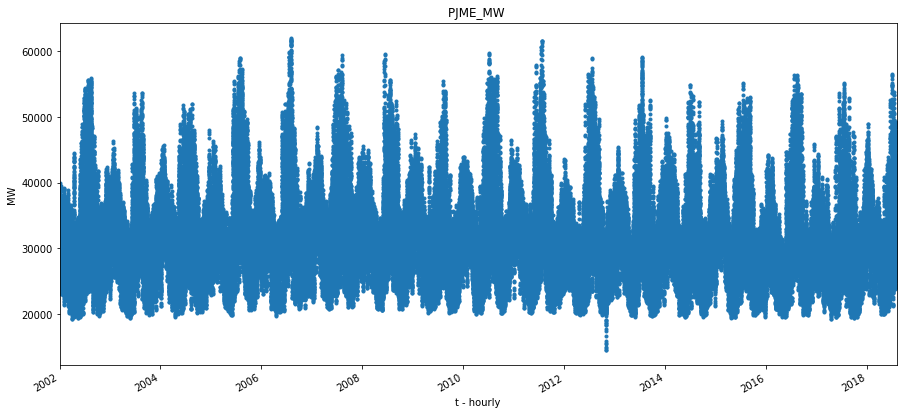

In [247]:
_ = df['PJME_MW'].plot( style='.', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t - hourly')
plt.show()

Это было почасовое потребление, посмотрим на ежедневное, недельное и месячное

In [252]:
df_d = df.resample('D').mean()

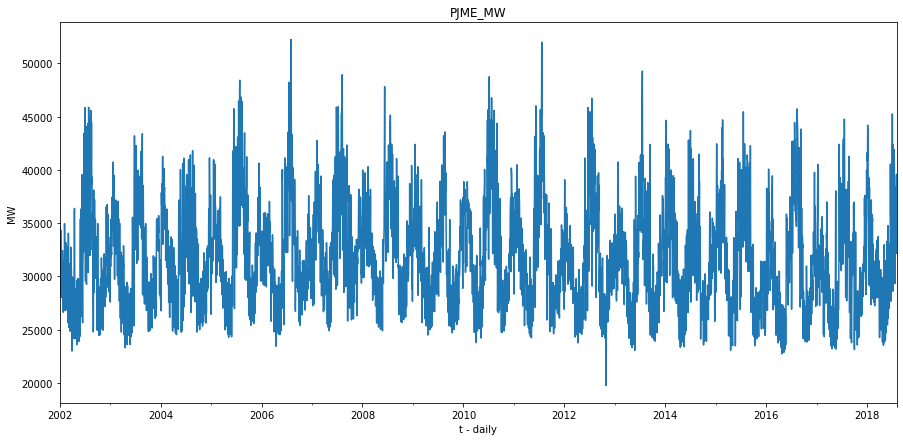

In [253]:
_ = df_d['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t - daily')
plt.show()

In [250]:
df_w = df.resample('W').mean()

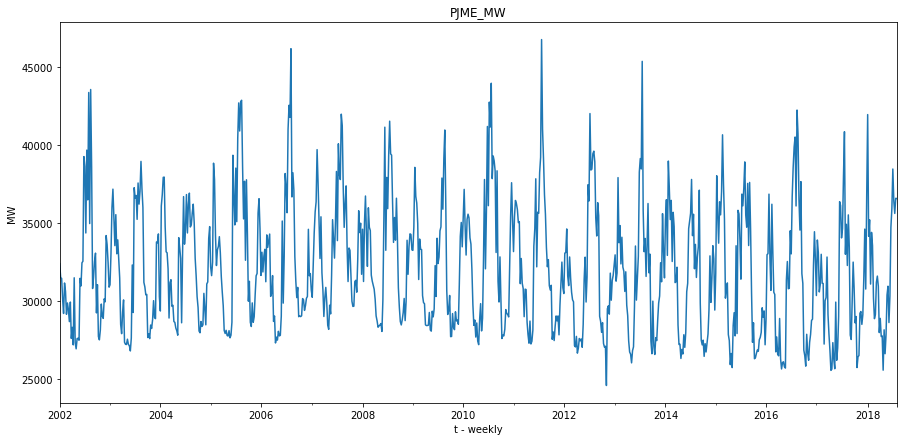

In [251]:
_ = df_w['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t - weekly')
plt.show()

In [278]:
df_mo = df.resample('M').mean()

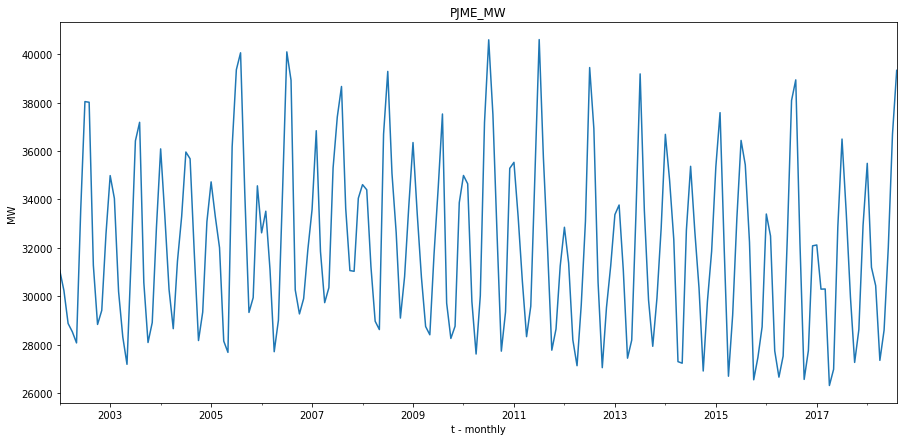

In [279]:
_ = df_mo['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t - monthly')
plt.show()

Мы видим цикличность потребления энергии. По виду данных, похоже на аддитивную сезонную модель. На месячном интервале она более сглаженная, посмотрим на годовую. 

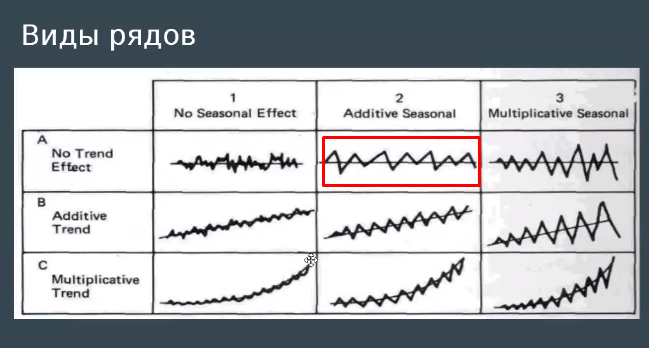

In [115]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = path + "additive.png", width=800, height=200)

In [258]:
df_y = df.resample('Y').mean()

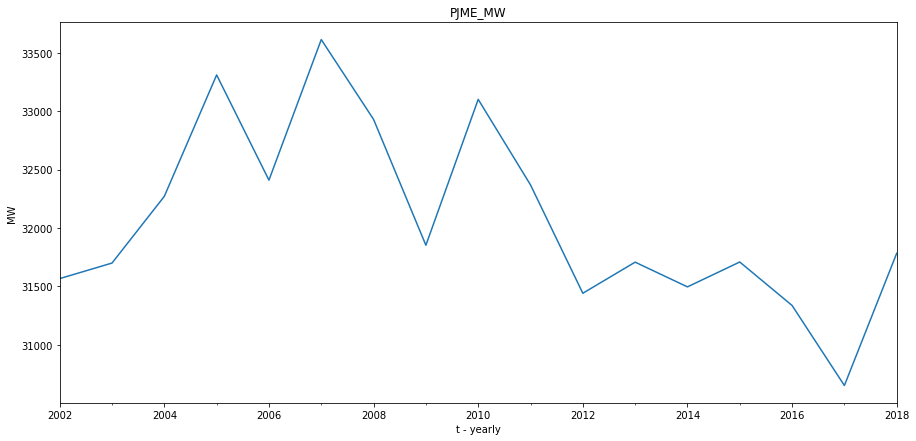

In [259]:
_ = df_y['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t - yearly')
plt.show()

## Проверим ряд на стационарность по тесту Дики-Фуллера(ADF) 

In [117]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Обращаемся к тесту с параметром regression='ctt' - анализировать на постоянные составляющие , линейные и квадратичные тренды. Первый параметр должен содержать одномерный массив или Series

In [118]:
# Проверка ряда на стационарность по часовым частотам

In [260]:
DF_data_h = sm.tsa.stattools.adfuller(df['PJME_MW'].values,regression='ctt')
DF_data_h

(-20.07144387552255,
 0.0,
 75,
 145298,
 {'1%': -4.371209756407774,
  '5%': -3.8324306460238056,
  '10%': -3.553285187108092},
 2092088.4565295193)

In [120]:
print (f'Ключевой показатель теста = {DF_data_h[1]}')

Ключевой показатель теста = 0.0


Ключевой показатель теста = 0.0, ряд стационарен. 

In [ ]:
# Проверка ряда на стационарность по дневным частотам

In [262]:
DF_data_d = sm.tsa.stattools.adfuller(df_d['PJME_MW'].values,regression='ctt')
DF_data_d

(-8.365362138567198,
 4.282974615268831e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Ключевой показатель теста = 4.28, ряд нестационарен.

In [121]:
# Проверка ряда на стационарность по месячным частотам

In [263]:
DF_data_m = sm.tsa.stattools.adfuller(df_w['PJME_MW'].values,regression='ctt')
DF_data_m

(-13.618743234517353,
 3.1785518401463206e-22,
 11,
 854,
 {'1%': -4.384748970317034,
  '5%': -3.839322655125974,
  '10%': -3.5575526054344873},
 15405.229437796354)

Ключевой показатель теста = 0.5247860093675522, ряд нестационарен. 

В месячном потреблении у потребления энергии есть явные сезоны, а в годовом наблюдаются уже нисходящие тренды.

## Сглаживание, выделение тренда.

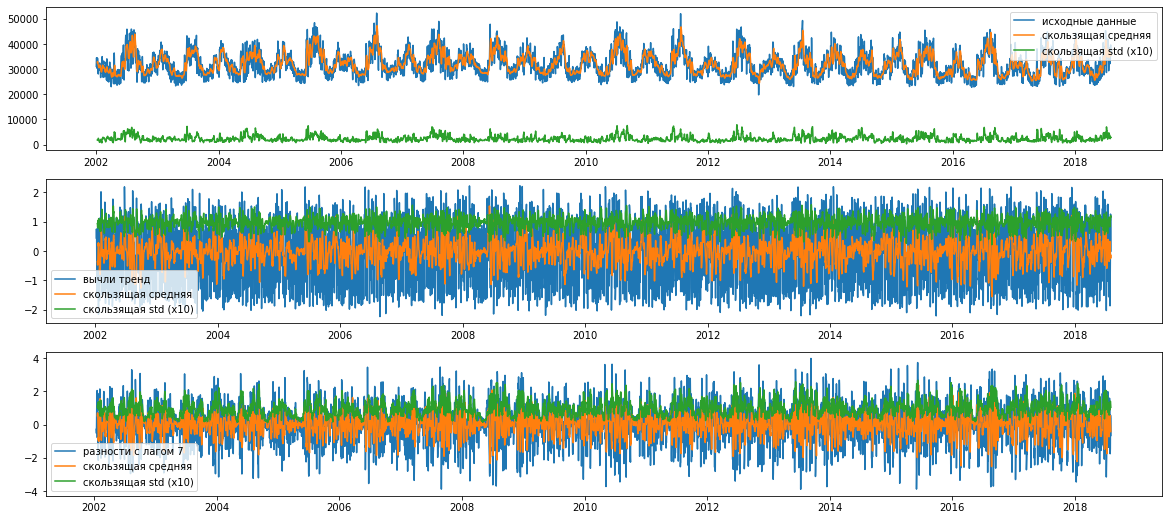

In [268]:
#сделаем окно на 1 неделю
N2 = 7

df_d['z_data'] = (df_d['PJME_MW'] - df_d['PJME_MW'].rolling(window=7).mean()) / df_d['PJME_MW'].rolling(window=N2).std()
df_d['zp_data'] = df_d['z_data'] - df_d['z_data'].shift(N2)

def plot_rolling(df_d):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(df_d.index, df_d['PJME_MW'], label='исходные данные')
    ax[0].plot(df_d['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(df_d['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(df_d.index, df_d.z_data, label="вычли тренд")
    ax[1].plot(df_d.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(df_d.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(df_d.index, df_d.zp_data, label="разности с лагом " + str(N2))
    ax[2].plot(df_d.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(df_d.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(df_d) 

Попробуем учитывать предшествующее значение с коэффициентом памяти, например вот так (x(i)a + (1-a)(x(n-i+1)* a + (1-a)( ...+ (1-a)(x(i-n)))) - получим экспоненциальное сглаживание. 

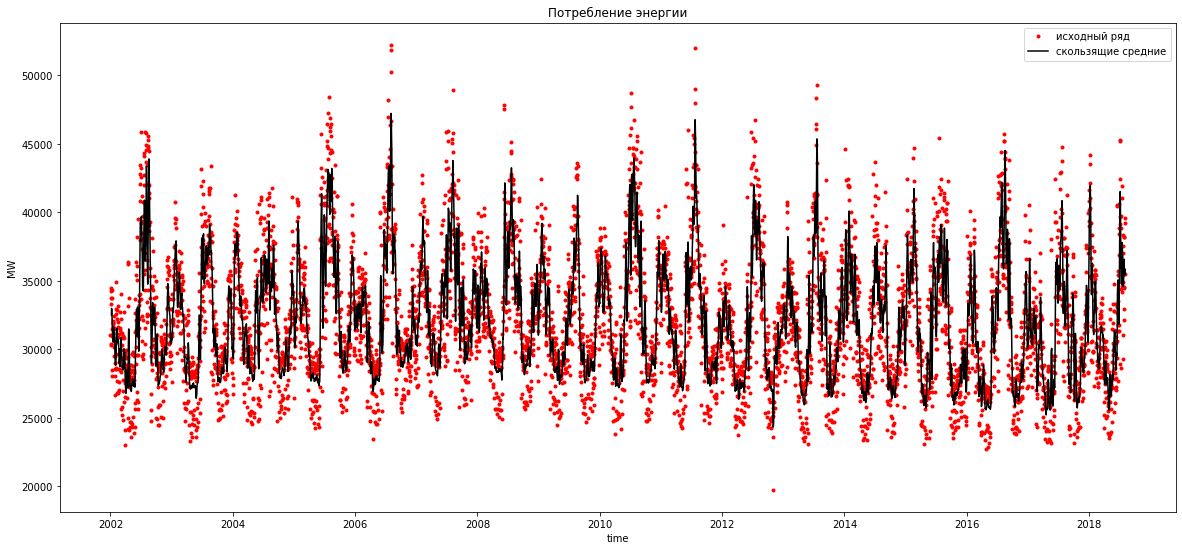

In [272]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# чем больше альфа, тем выше память у ряда, то есть повторяет историю
b_ar_exp_1 = exponential_smoothing(df_d['PJME_MW'], 0.07)

plt.figure(figsize=(20, 9))
plt.plot(df_d.index, df_d['PJME_MW'], '.r', label='исходный ряд')
plt.plot(df_d['PJME_MW'].rolling(window=7).mean(), label="скользящие средние", color = 'k');
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('Потребление энергии')
plt.show()

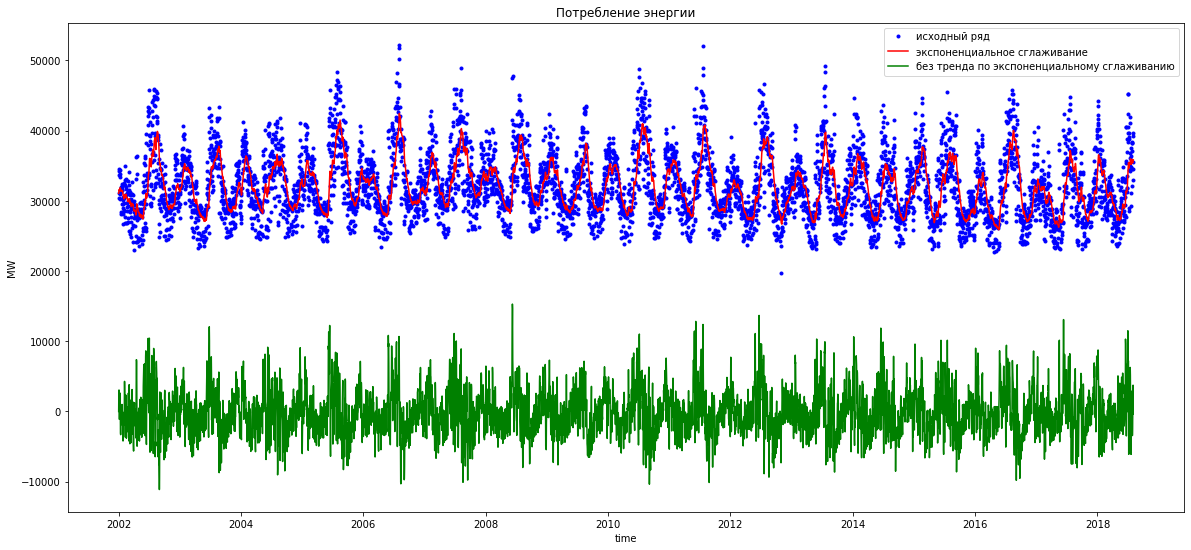

In [304]:
b_ar_exp_1 = exponential_smoothing(df_d['PJME_MW'], 0.06)

plt.figure(figsize=(20, 9))
plt.plot(df_d.index, df_d['PJME_MW'], '.b', label='исходный ряд')

plt.plot(df_d.index,b_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(df_d.index, df_d['PJME_MW'] - b_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('Потребление энергии')
plt.show()

Результаты сглаживания по экспоненциальной модели заметно ближе и больше похожи на основное направление изменения потребления энергии, чем обычное скользящее среднее. 

In [310]:
df_d.isnull().sum()

PJME_MW             0
year                0
month               0
dayofmonth          0
quarter             0
dayofyear           0
weekofyear          0
dayofweek           0
hour                0
is_holiday          0
is_prev_holiday     0
is_next_holiday     0
z_data              6
zp_data            13
dtype: int64

ряд нестационарен

## Добавление признаков

In [311]:
#Возьмем за основу для модели экспоненциально сглаживание 
df_m = pd.DataFrame({'value': df_d['PJME_MW']}, index=df_d.index)

In [312]:
 # добавили историю на глубину 3 измерения от текущего (р=3)
df_m['t'] = 0
df_m.iloc[1:,1]=df_m.iloc[:-1,0].values
df_m['t1']=0
df_m.iloc[2:,2]=df_m.iloc[:-2,0].values
df_m['t2']=0
df_m.iloc[3:,3]=df_m.iloc[:-3,0].values

In [313]:
# добавили сглаживание (3 вида - просто для коллекции)
df_m['exp_0_01'] = exponential_smoothing(df_m.value, 0.01)
df_m['exp_0_03'] = exponential_smoothing(df_m.value, 0.03)
df_m['exp_0_08'] = exponential_smoothing(df_m.value, 0.08)

In [314]:
# добавим разности - 1-й порядок
df_m['diff1'] = df_m['value'].diff()

In [315]:
df_m.head()

,value,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,NaN
2002-01-02,34261.541667,31080.739130,0.000000,0.000000,31112.547156,31176.163207,31335.203333,3180.802536
2002-01-03,34511.875000,34261.541667,31080.739130,0.000000,31146.540434,31276.234560,31589.337067,250.333333
2002-01-04,33715.458333,34511.875000,34261.541667,31080.739130,31172.229613,31349.411274,31759.426768,-796.416667
2002-01-05,30405.125000,33715.458333,34511.875000,34261.541667,31164.558567,31321.082685,31651.082627,-3310.333333


In [316]:
# добавим скользящее среднее с длиной сглаживания 7, 14 и 30 дней
df_m['ma_1'] = df_m.value.rolling(1).mean().values
df_m['ma_3'] = df_m.value.rolling(3).mean().values
df_m['ma_5'] = df_m.value.rolling(5).mean().values

In [317]:
df_m.isnull().sum()

value       0
t           0
t1          0
t2          0
exp_0_01    0
exp_0_03    0
exp_0_08    0
diff1       1
ma_1        0
ma_3        2
ma_5        4
dtype: int64

In [318]:
# добавим среднеквадратиечкое отклонение  с длиной сглаживания 7, 14 и 30 дней
df_m['std_1'] = df_m.value.rolling(1).std().values
df_m['std_3'] = df_m.value.rolling(3).std().values
df_m['std_5'] = df_m.value.rolling(5).std().values

In [319]:
df_m.fillna(0, inplace=True)
df_m.head(4)

,value,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1,ma_1,ma_3,ma_5,std_1,std_3,std_5
Date,,,,,,,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.00000,31080.739130,31080.739130,31080.739130,0.000000,31080.739130,0.000000,0.0,0.0,0.000000,0.0
2002-01-02,34261.541667,31080.739130,0.000000,0.00000,31112.547156,31176.163207,31335.203333,3180.802536,34261.541667,0.000000,0.0,0.0,0.000000,0.0
2002-01-03,34511.875000,34261.541667,31080.739130,0.00000,31146.540434,31276.234560,31589.337067,250.333333,34511.875000,33284.718599,0.0,0.0,1912.801824,0.0
2002-01-04,33715.458333,34511.875000,34261.541667,31080.73913,31172.229613,31349.411274,31759.426768,-796.416667,33715.458333,34162.958333,0.0,0.0,407.257759,0.0


## Разделим данные на тестовые и тренировочные во временных рядах

In [320]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train, test = split_data(df_m, '20-10-2016')

In [321]:
train.head()

,value,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1,ma_1,ma_3,ma_5,std_1,std_3,std_5
Date,,,,,,,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000,31080.739130,0.000000,0.000000,0.0,0.000000,0.000000
2002-01-02,34261.541667,31080.739130,0.000000,0.000000,31112.547156,31176.163207,31335.203333,3180.802536,34261.541667,0.000000,0.000000,0.0,0.000000,0.000000
2002-01-03,34511.875000,34261.541667,31080.739130,0.000000,31146.540434,31276.234560,31589.337067,250.333333,34511.875000,33284.718599,0.000000,0.0,1912.801824,0.000000
2002-01-04,33715.458333,34511.875000,34261.541667,31080.739130,31172.229613,31349.411274,31759.426768,-796.416667,33715.458333,34162.958333,0.000000,0.0,407.257759,0.000000
2002-01-05,30405.125000,33715.458333,34511.875000,34261.541667,31164.558567,31321.082685,31651.082627,-3310.333333,30405.125000,32877.486111,32794.947826,0.0,2177.842275,1910.225157


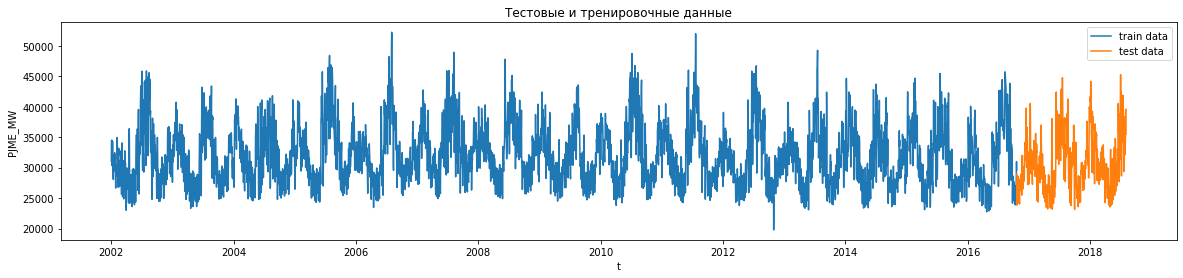

In [322]:
#поставим глубину прогноза 1
h = 1

X_train_1 = train.iloc[:-h, :]
y_train_1 = train['value'].values[h:]
X_test_1 = test.iloc[:-h, :]
y_test_1 = test['value'].values[h:]

plt.figure(figsize=(20, 4))
plt.xlabel('t')
plt.ylabel('PJME_MW')
plt.plot(train.index.get_level_values('Date'), train['value'], label='train data' )
plt.plot(test.index.get_level_values('Date'), test['value'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

In [323]:
from sklearn.ensemble import GradientBoostingRegressor

In [324]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

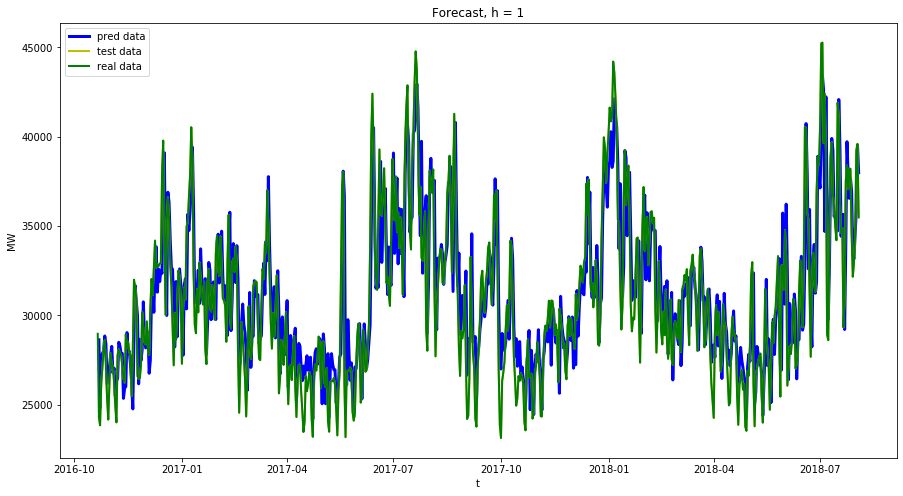

Mean absolute percantage error (h = 1): 5.5467%


In [326]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

model.fit(X_train_1, y_train_1) 

y_test_pred_1 = model.predict(X_test_1)

plt.figure(figsize=(15, 8))

plt.title('Forecast, h = 1')

plt.xlabel('t')
plt.ylabel('MW')
plt.plot(test.index[h:], y_test_pred_1, label='pred data', linewidth=3.0, color = 'b')
plt.plot(test.index[h:], y_test_1, label='test data', linewidth=2.0, color = 'y' )
plt.plot(df_m.loc['2016-10-21':].index, df_m.loc['2016-10-21':]['value'], label='real data', linewidth=2.0, color = 'g')

plt.legend()
plt.show()

mape_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=y_test_pred_1)

print(f'Mean absolute percantage error (h = 1): {np.round(mape_1, 4)}%')

In [327]:
#поставим глубину прогноза 10 дней
h = 10

X_train_10 = train.iloc[:-h, :]
y_train_10 = train['value'].values[h:]
X_test_10 = test.iloc[:-h, :]
y_test_10 = test['value'].values[h:]

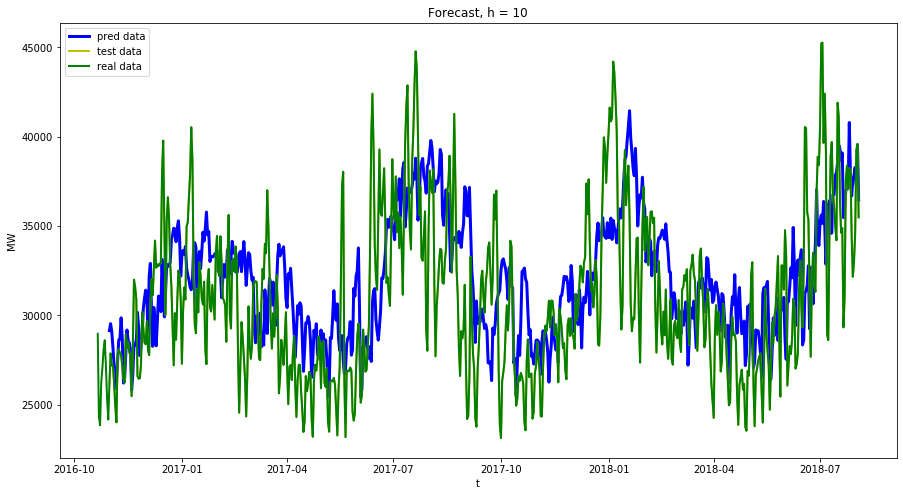

Mean absolute percantage error (h = 1): 10.5669%


In [329]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

model.fit(X_train_10, y_train_10) 

y_test_pred_10 = model.predict(X_test_10)

plt.figure(figsize=(15, 8))

plt.title('Forecast, h = 10')

plt.xlabel('t')
plt.ylabel('MW')
plt.plot(test.index[h:], y_test_pred_10, label='pred data', linewidth=3.0, color = 'b')
plt.plot(test.index[h:], y_test_10, label='test data', linewidth=2.0, color = 'y' )
plt.plot(df_m.loc['2016-10-21':].index, df_m.loc['2016-10-21':]['value'], label='real data', linewidth=2.0, color = 'g')

plt.legend()
plt.show()

mape_10 = mean_absolute_percentage_error(y_true=y_test_10, y_pred=y_test_pred_10)

print(f'Mean absolute percantage error (h = 1): {np.round(mape_10, 4)}%')

## 2. Оцените ошибку модели из п.1 .

In [336]:
print( f'Разница в ошибке в пользу глубины прогноза 1 неделя составляет {round((mape_10 - mape_1), 2)} %')

Разница в ошибке в пользу глубины прогноза 1 неделя составляет 5.02 %


## 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Точность прогноза зависит от количества данных, особенно в данном случае с цикличными рядами, поэтому выиграл прозноз с глубиной в 1 неделю.

## 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном - нестационарный, цикличность

б) Количество денег, которые тратят покупатели в интернет магазине. - нестационарный, тренд + сезонность, но зависит от периода

в) Вес растущего котенка. - нестационарный с восходящим трендом, если не будет болеть 

г) Прирост объема деревьев в лесу от времени - нестационарный с восходящим трендом, если не прийдут лесорубы